In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
from pathlib import Path

def generate_penetrance_df(cns_files: list[Path], bin_size : int = 1_000_000, gain_threshold : float = 0.32, loss_threshold: float = -0.4):
    
    # Create an empty list to store bin information
    all_bins = []
    
    # Iterate over each segmentation file
    for file in cns_files:
        sample_data = pd.read_csv(file, sep='\t')
        sample_id = file.name.split('.')[0] # Extract sample ID from filename
        
        # Iterate through each segment in the sample
        for index, row in sample_data.iterrows():
            chrom = row['chromosome']
            start = row['start']
            end = row['end']
            log2_ratio = row['log2']
            
            # Determine which bins overlap with this segment
            bin_start = (start // bin_size) * bin_size
            bin_end = ((end // bin_size) + 1) * bin_size
            
            for bin_pos in range(bin_start, bin_end, bin_size):
                overlap_start = max(start, bin_pos)
                overlap_end = max(end, bin_pos + bin_size)
                
                if overlap_start < overlap_end: # Ensure there is an overlap
                    overlap_fraction = (overlap_end - overlap_start) / (end - start)
                    
                    all_bins.append({
                        'Chromosome': chrom,
                        'Bin_Start': bin_pos,
                        'Bin_End': bin_pos + bin_size,
                        'Sample_ID': sample_id,
                        'Gain': 1 if log2_ratio > gain_threshold else 0,
                        'Loss': 1 if log2_ratio < loss_threshold else 0,
                        'Overlap_Fraction': overlap_fraction
                    })
    
    # Convert the bin list to a dataframe
    bins_df = pd.DataFrame(all_bins)
    
    
    # Group by chromosome and bin to calculate the penetrance
    penetrance_df = bins_df.groupby(['Chromosome', 'Bin_Start', 'Bin_End']).agg(
        Gain_Penetrance=('Gain', 'mean'),
        Loss_Penetrance=('Loss', 'mean')
    ).reset_index()
    
    # Convert to percentage
    penetrance_df['Gain_Penetrance'] *= 100
    penetrance_df['Loss_Penetrance'] *= 100
    
    return penetrance_df

import pandas as pd
import matplotlib.pyplot as plt

def plot_penetrance(
    data: pd.DataFrame,
    title: str = 'Genome-Wide DNA Copy Number Penetrance',
    bin_size: int = 1_000_000,
    gain_threshold: float = 0.32,
    loss_threshold: float = -0.4,
    y_range: tuple = (-50, 50),
    y_tick_step: int = 10,
    output_file: str = None
):
    chromosomes = sorted(data['Chromosome'].unique(), key=lambda x: (x.isdigit(), x))
    fig, ax = plt.subplots(figsize=(15, 6), constrained_layout=True)

    x_pos = 0
    x_ticks = []
    x_labels = []
    chromosome_boundaries = []

    # Prepare dynamic labels
    gain_label = f'Gain (log2 > {gain_threshold})'
    loss_label = f'Loss (log2 < {loss_threshold})'

    for chrom in chromosomes:
        chrom_data = data[data['Chromosome'] == chrom]
        x = chrom_data['Bin_Start'] + x_pos - chrom_data['Bin_Start'].min()

        ax.fill_between(
            x, 0, chrom_data['Gain_Penetrance'],
            color='red', alpha=1,
            label=gain_label if chrom == chromosomes[0] else ""
        )
        ax.fill_between(
            x, 0, -chrom_data['Loss_Penetrance'],
            color='blue', alpha=1,
            label=loss_label if chrom == chromosomes[0] else ""
        )

        length = chrom_data['Bin_End'].max() - chrom_data['Bin_Start'].min() + bin_size
        x_pos += length

        x_ticks.append(x_pos - length / 2)
        x_labels.append(chrom)
        chromosome_boundaries.append(x_pos)

    # set x-limits
    ax.set_xlim(0, chromosome_boundaries[-1])

    # set y-limits and ticks based on y_range
    y_min, y_max = y_range
    ax.set_ylim(y_min, y_max)
    ax.set_yticks(range(y_min, y_max + 1, y_tick_step))

    # labels & grid
    ax.set_title(title)
    ax.set_xlabel('Genomic Position (by Chromosome)')
    ax.set_ylabel('Penetrance (%)')

    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_labels)
    for b in chromosome_boundaries + [0]:
        ax.axvline(x=b, color='black', linestyle='-', linewidth=0.8)
    ax.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5)

    ax.legend(
        loc='center left',
        bbox_to_anchor=(1.02, 0.5),
        borderaxespad=0
    )

    # save or show
    if output_file:
        plt.savefig(output_file, dpi=300, bbox_inches='tight')
    else:
        plt.show()


Processing 6555_Lung_carcinoma with 57 valid samples...
Processing 6711_Cutaneous_SCC with 62 valid samples...
Processing 6712_Oral_SCC with 42 valid samples...
Processing 6713_Cutaneous_MCT with 40 valid samples...
Processing 6841_Meningioma with 28 valid samples...
Processing 6864_Pancreatic_carcinoma with 29 valid samples...
Processing 6945_Cholangiocarcinoma with 30 valid samples...
Processing 6973_OSA with 25 valid samples...
Processing 6982_Lymphoma with 51 valid samples...
Processing 6990_Mammary_carcinoma with 47 valid samples...
Processing 7040_BCC with 40 valid samples...
Processing 7097_CRC with 34 valid samples...
Processing 7098_Glioma with 7 valid samples...


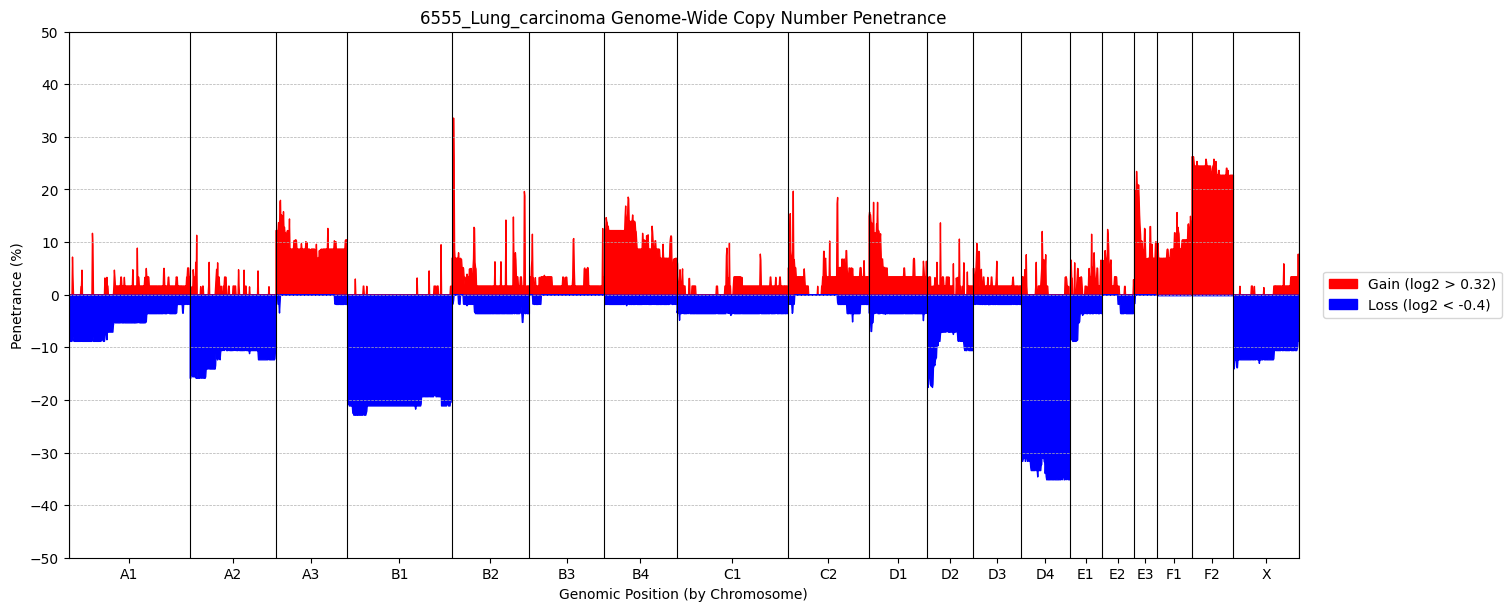

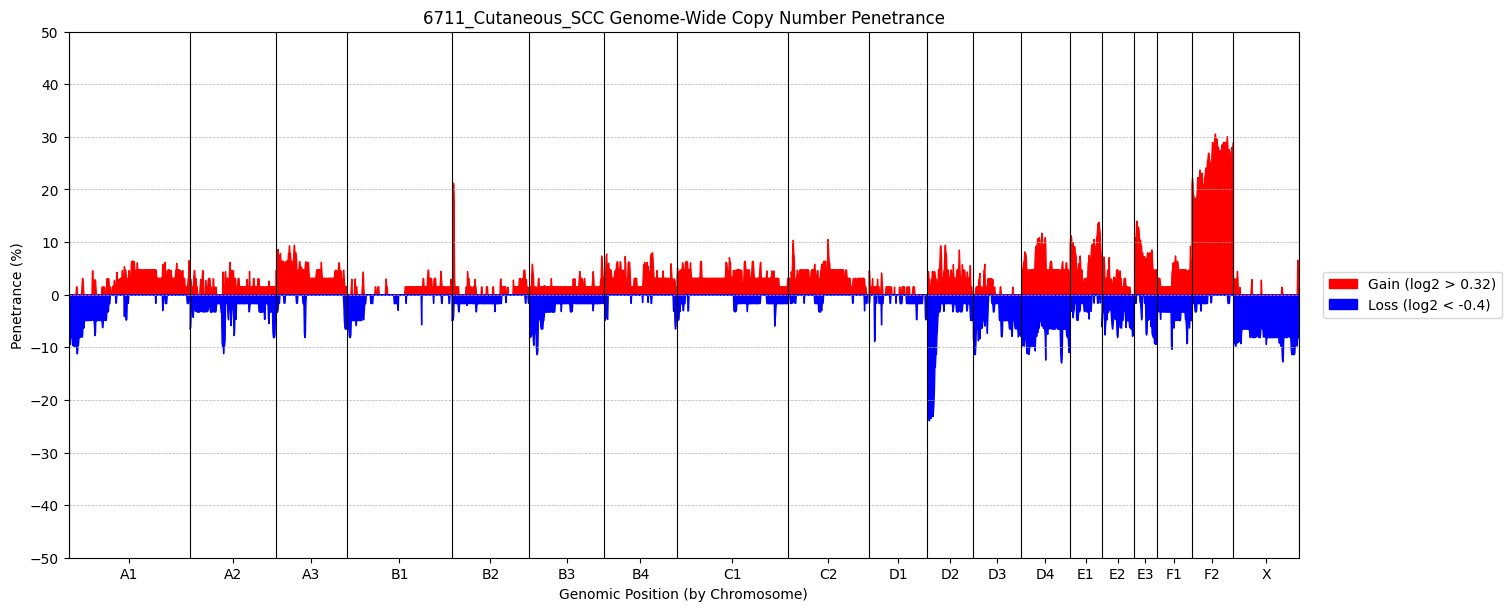

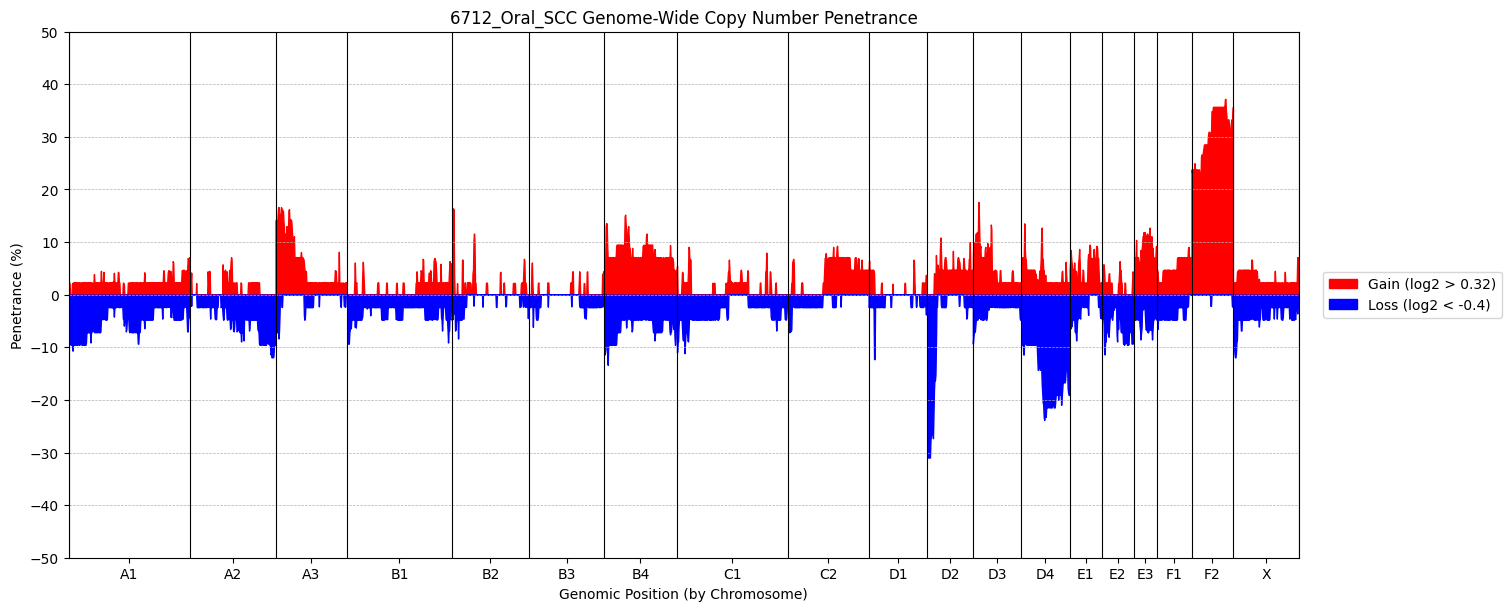

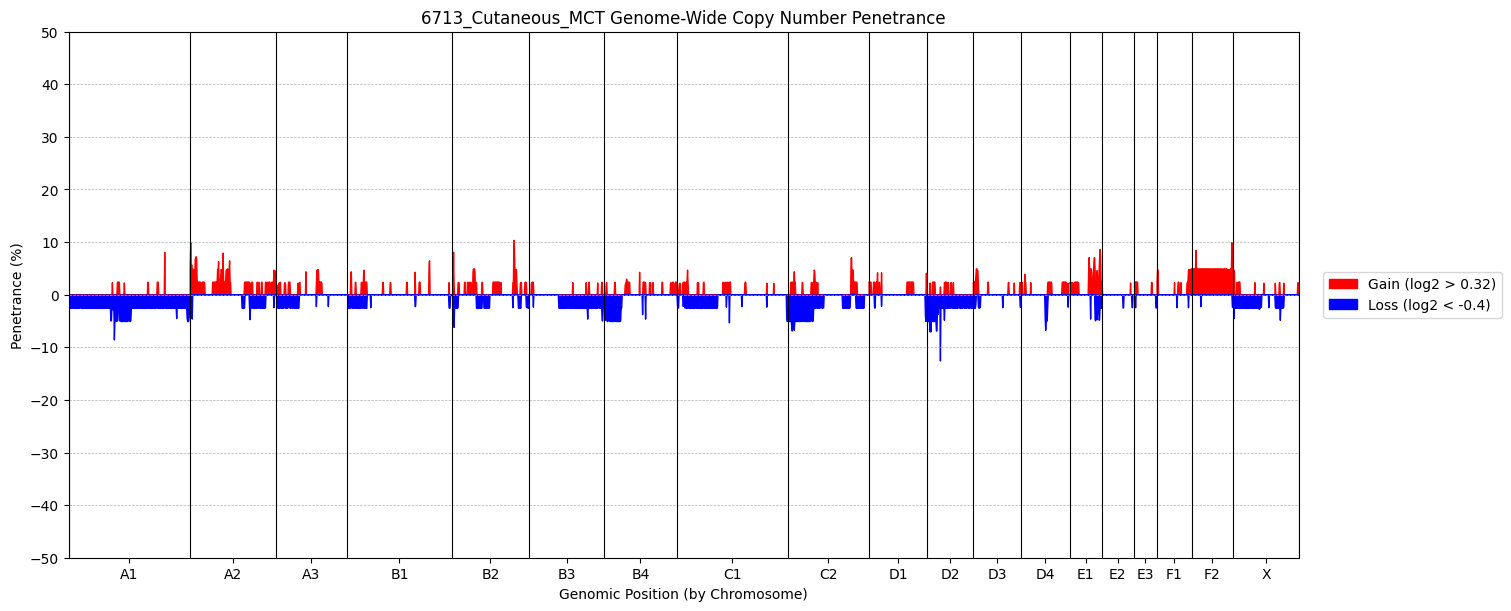

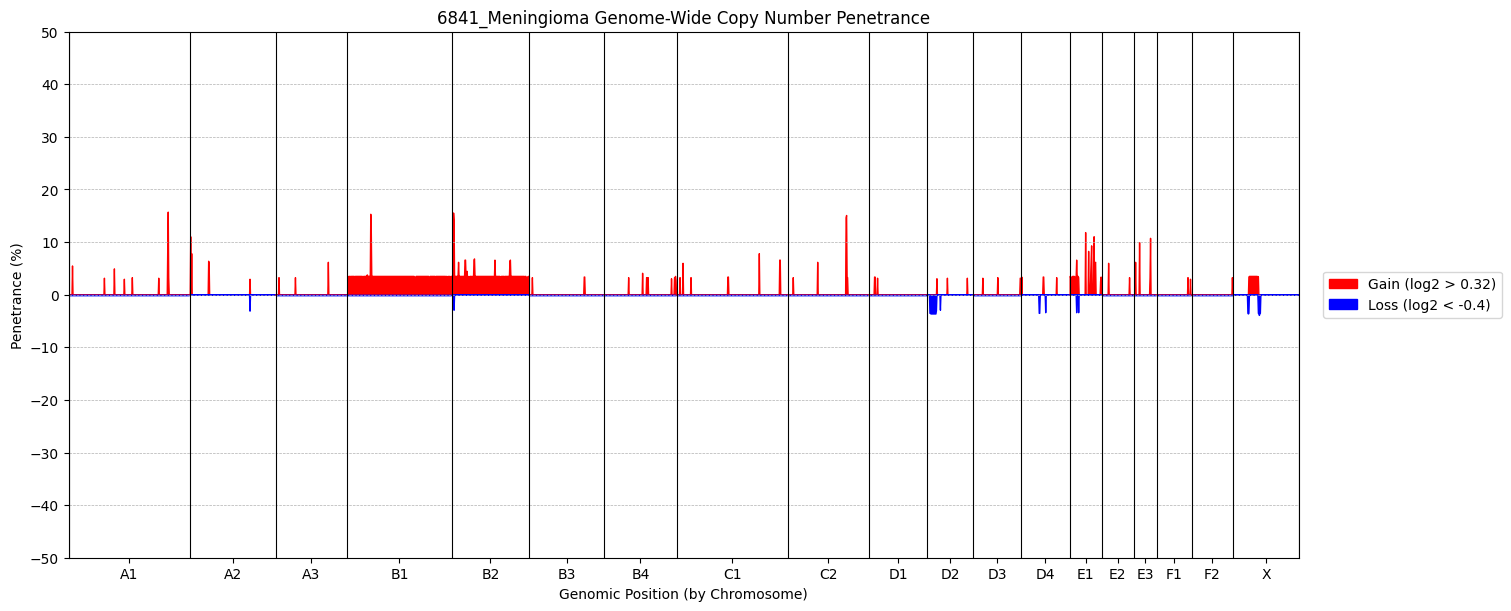

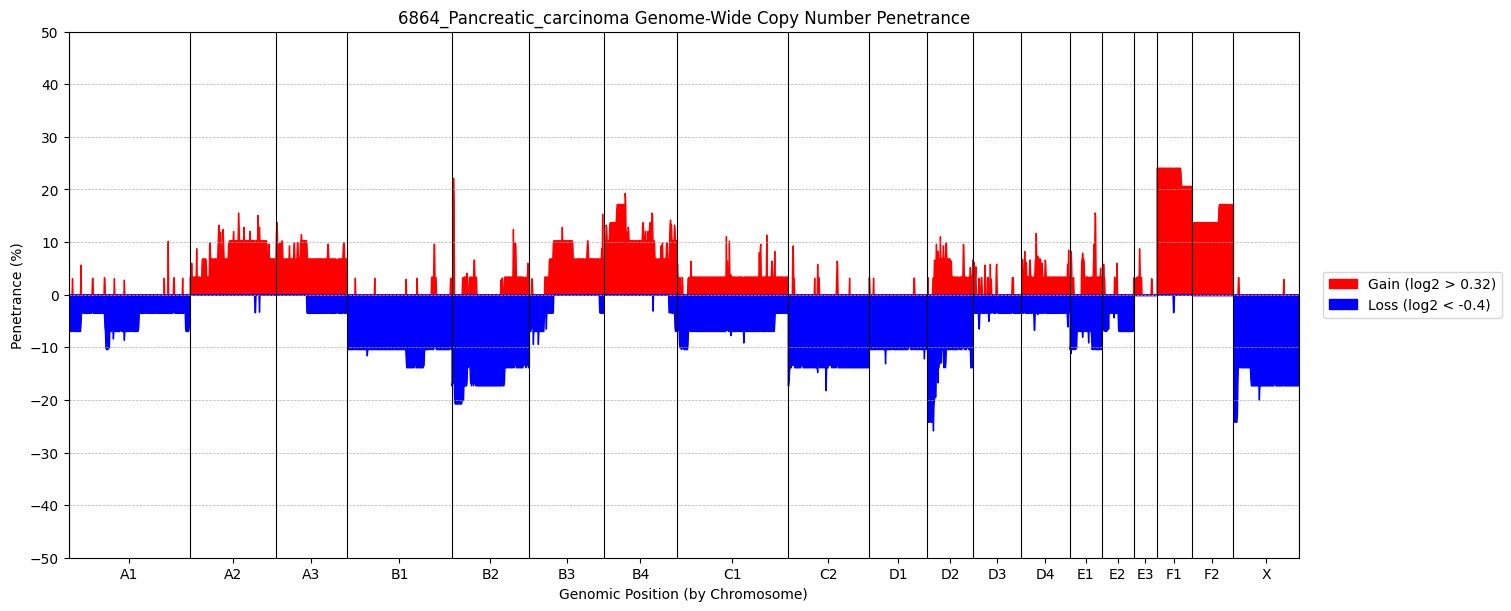

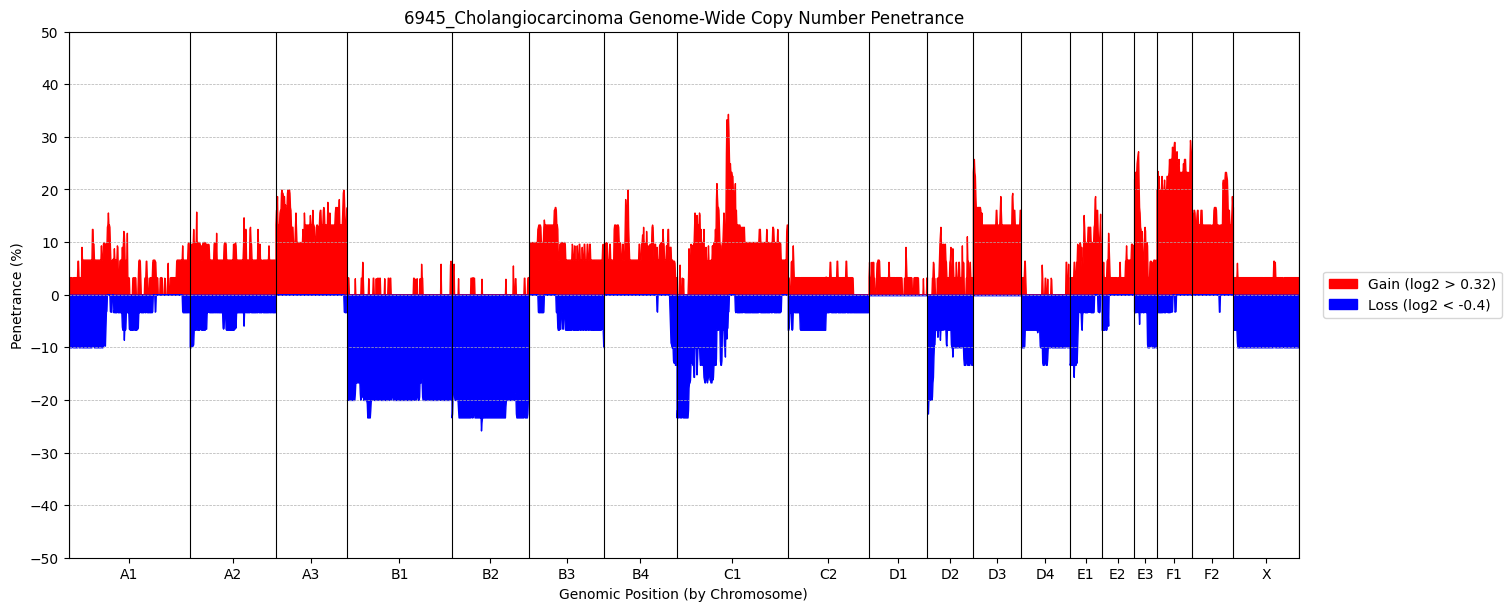

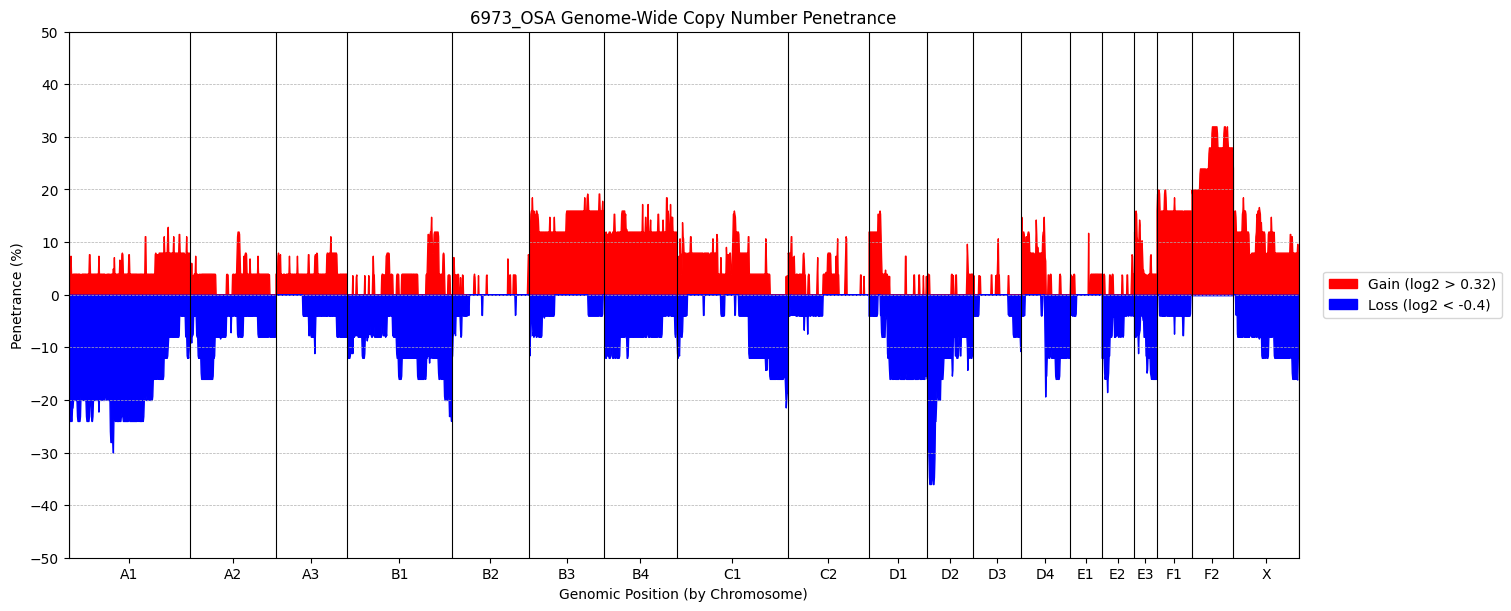

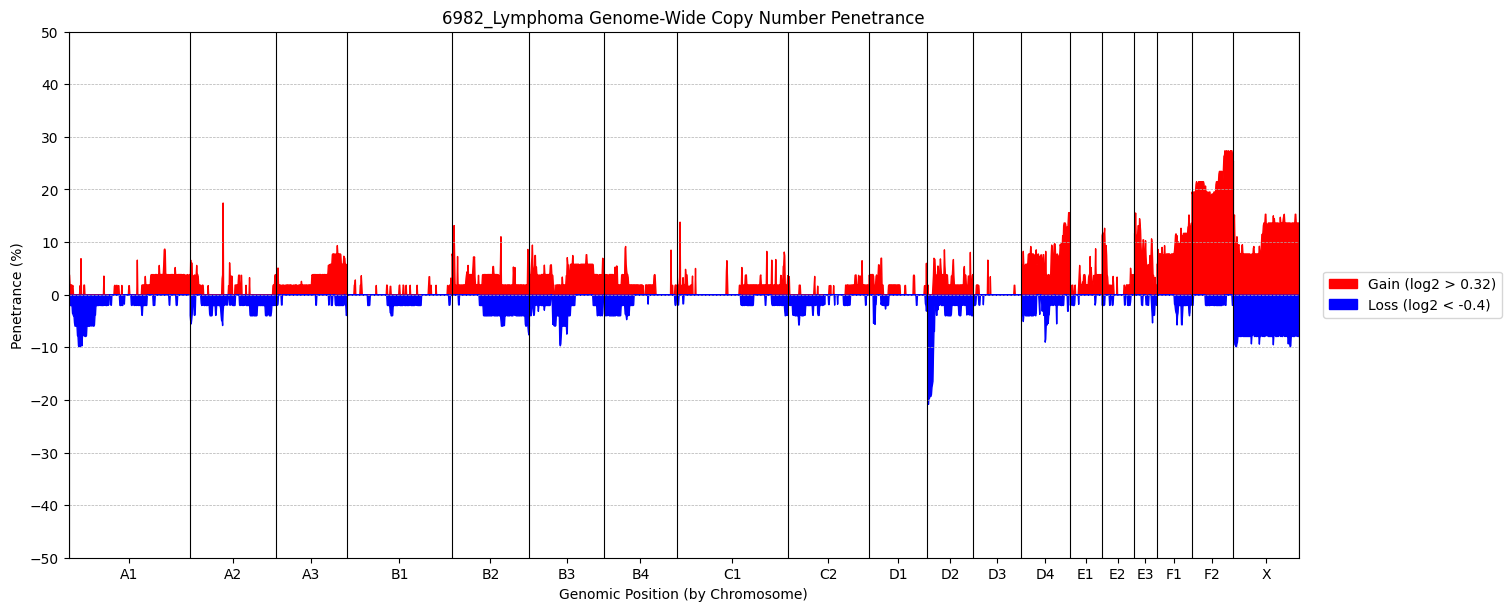

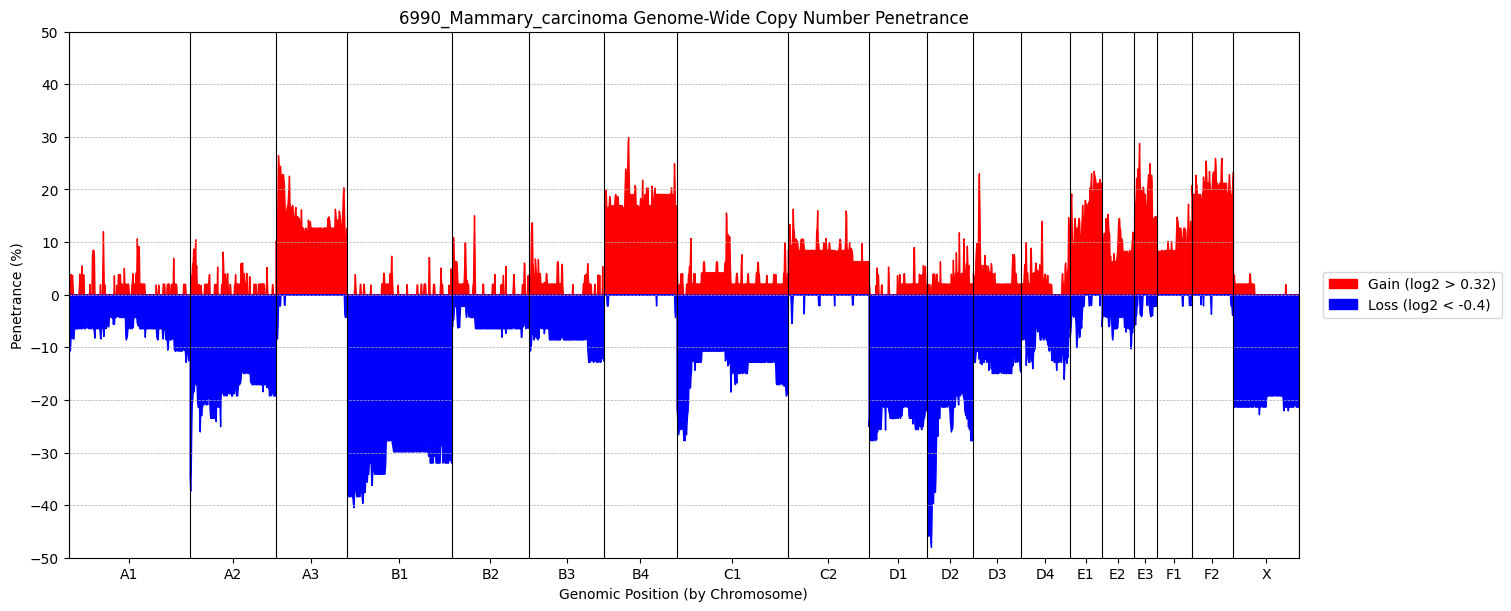

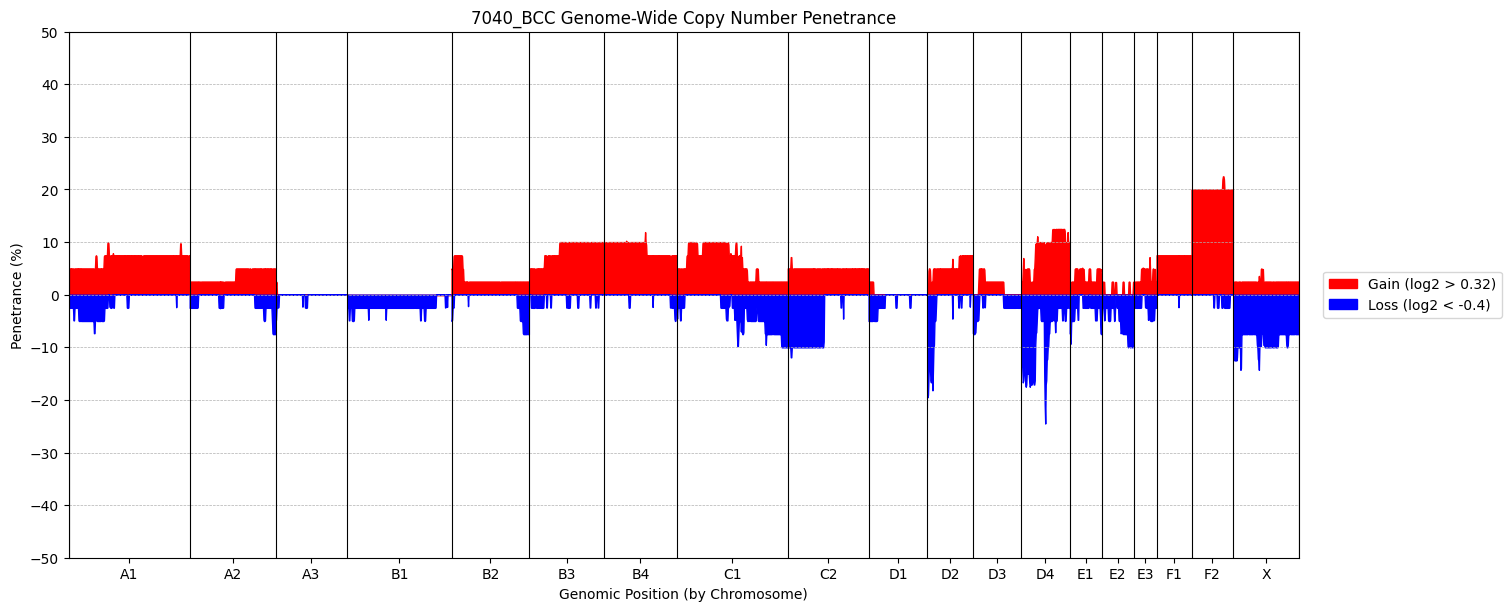

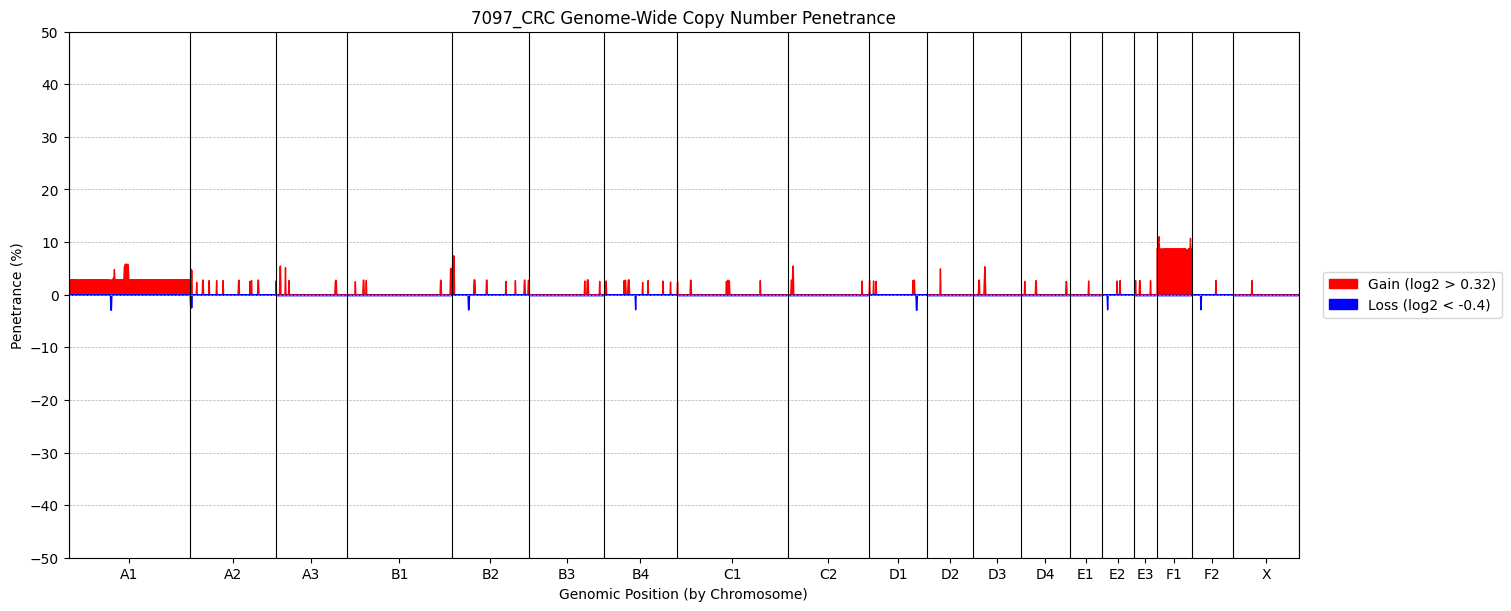

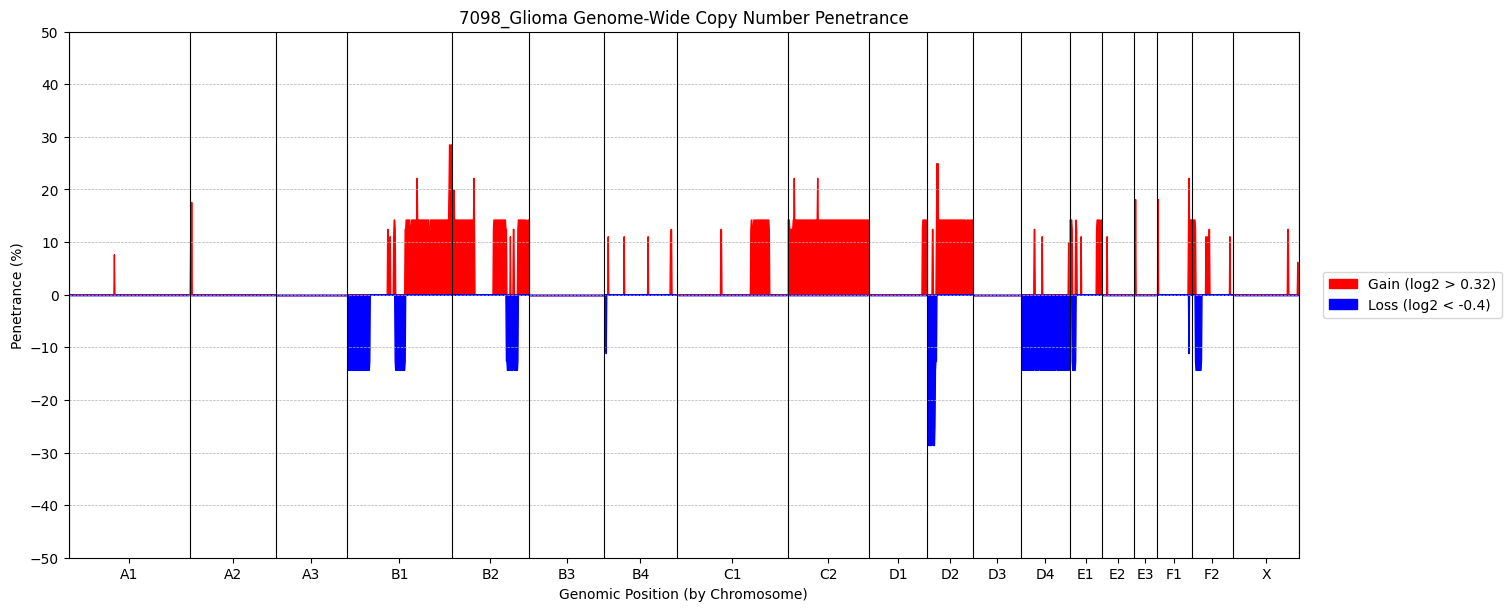

In [5]:
# Define paths and read sample list
base_dir = Path("./data/cnvkit_segmentation_files")
samples_to_exclude_file = Path("./data/FUR_cat.samples_to_exclude.nucleotide_variants.txt")
samples_to_exclude = samples_to_exclude_file.read_text().splitlines()

# Output directory
output_dir = Path("penetrance_plots")
output_dir.mkdir(exist_ok=True)

# Study directories
study_dirs = [
    "6555_Lung_carcinoma", "6711_Cutaneous_SCC", "6712_Oral_SCC", "6713_Cutaneous_MCT",
    "6841_Meningioma", "6864_Pancreatic_carcinoma", "6945_Cholangiocarcinoma",
    "6973_OSA", "6982_Lymphoma", "6990_Mammary_carcinoma", "7040_BCC",
    "7097_CRC", "7098_Glioma"
]

# Loop through each study
for study in study_dirs:
    study_path = base_dir / study
    cns_files = glob.glob(str(study_path / "*.median_centred.cns"))
    filtered_cns_files = [Path(f) for f in cns_files if Path(f).name.split('.')[0] not in samples_to_exclude]

    print(f"Processing {study} with {len(filtered_cns_files)} valid samples...")
    penetrance_df = generate_penetrance_df(filtered_cns_files)

    plot_file = output_dir / f"{study}.penetrance_plot.pdf"
    plot_penetrance(penetrance_df, title=f"{study} Genome-Wide Copy Number Penetrance", bin_size=1_00_000, output_file=plot_file)

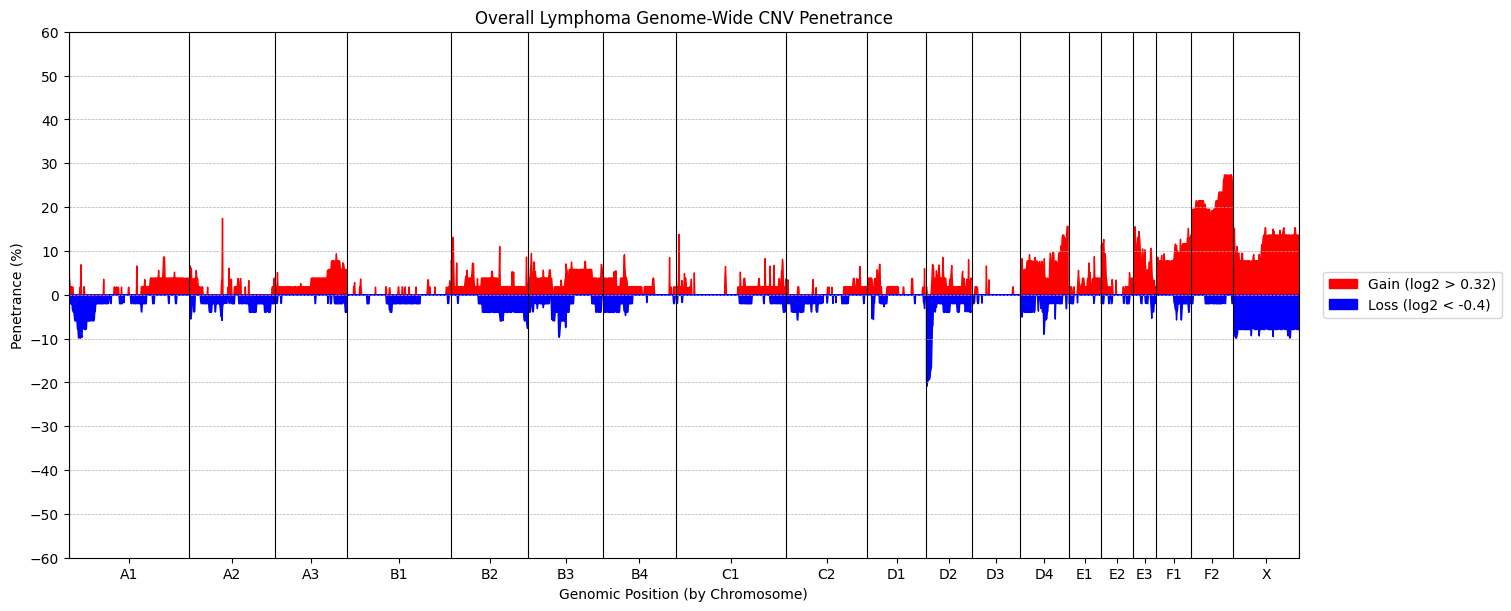

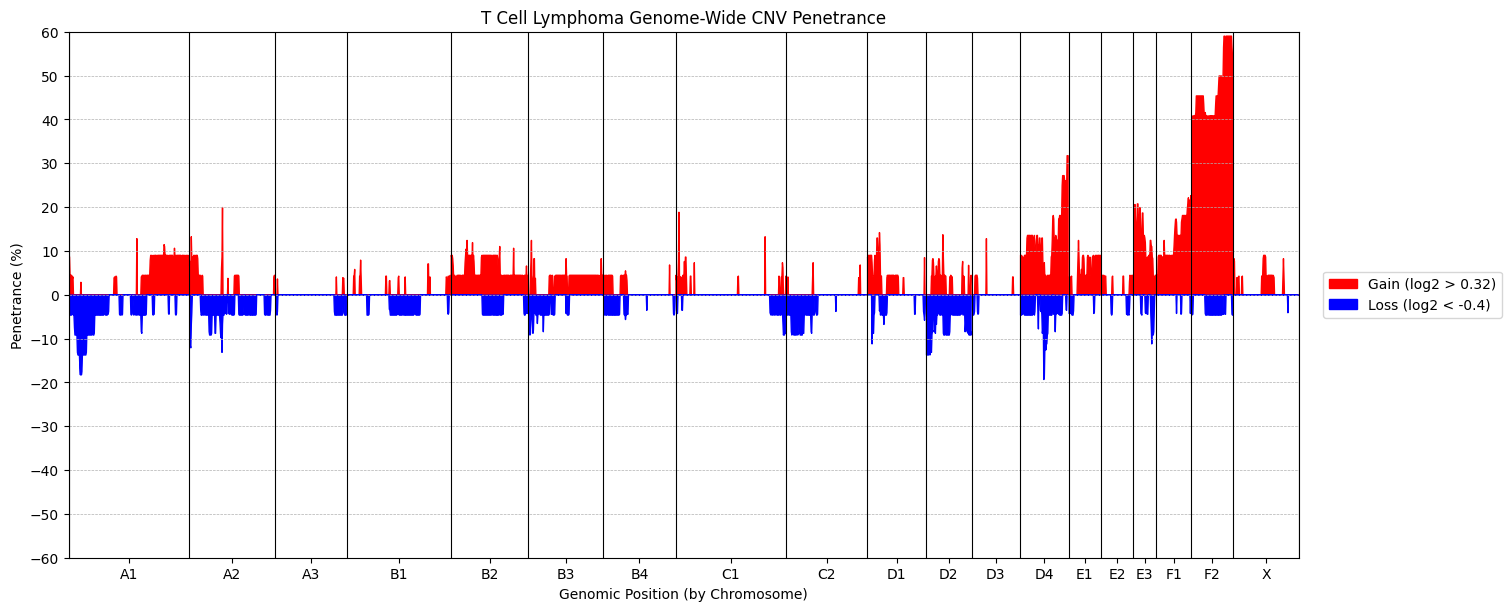

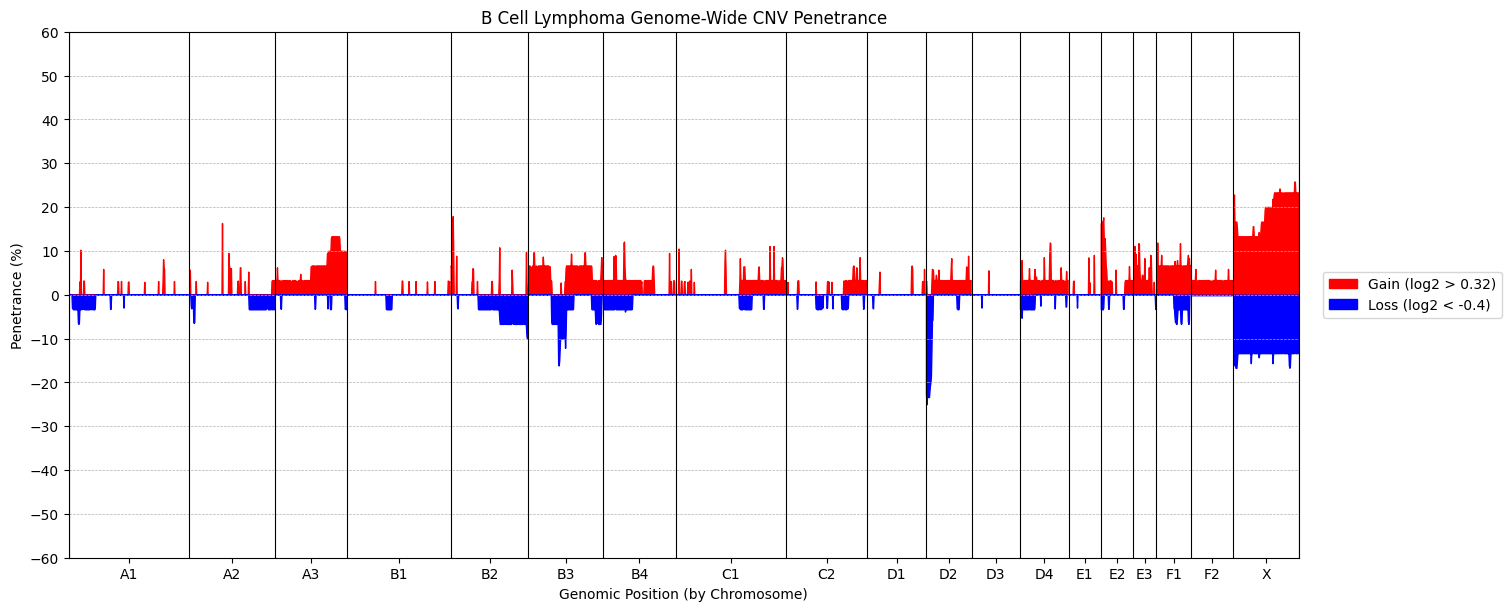

In [8]:
# Create seperate penetrance plots for lymphoma samples

#─── 1) Define the lymphoma samples ────────────────────────────────
T_CELL_LYMPHOMA_SAMPLES = [
    'CATD0572a','CATD0574a','CATD0575a','CATD0578a','CATD0579a','CATD0580a',
    'CATD0581a','CATD0585a','CATD0587a','CATD0588a','CATD0592a','CATD0593a',
    'CATD0596a','CATD0598a','CATD0601a','CATD0603a','CATD0606a','CATD0608a',
    'CATD0610a','CATD0678a','CATD0679a','CATD0680a','CATD0682a','CATD0683a',
    'CATD0684a','CATD0687a','CATD0721a','CATD0722a','CATD0724a'
]
NK_LYMPHOMA_SAMPLES   = ["CATD0596a"]

# All lymphoma samples 
ALL_LYMPHOMA_SAMPLES = [
    "CATD0572a","CATD0573a","CATD0574a","CATD0575a","CATD0576a","CATD0577a",
    "CATD0578a","CATD0580a","CATD0581a","CATD0582a","CATD0583a","CATD0584a",
    "CATD0585a","CATD0586a","CATD0587a","CATD0588a","CATD0589a","CATD0590a",
    "CATD0591a","CATD0592a","CATD0593a","CATD0594a","CATD0595a","CATD0596a",
    "CATD0600a","CATD0601a","CATD0603a","CATD0604a","CATD0606a","CATD0609a",
    "CATD0678a","CATD0679a","CATD0680a","CATD0682a","CATD0686a","CATD0687a",
    "CATD0719a","CATD0720a","CATD0721a","CATD0722a","CATD0723a","CATD0725a",
    "CATD0727a","CATD0729a","CATD0730a","CATD0731a","CATD0732a","CATD0733a",
    "CATD0734a","CATD0735a","CATD0736a"
]
# B‐cell = (all minus T‐cell) ∪ NK
B_CELL_LYMPHOMA_SAMPLES = list(
    (set(ALL_LYMPHOMA_SAMPLES) - set(T_CELL_LYMPHOMA_SAMPLES)) |
    set(NK_LYMPHOMA_SAMPLES)
)

#─── 2) Define the parameters for the lymphoma samples ────────────

base_dir = Path("/lustre/scratch127/bf14/analysis/fur_cnvkit/run_cnvkit_copy_number_calling_pipeline/all_studies_farm22")
study = "6982_Lymphoma"
cns_dir = base_dir / study

samples_to_exclude = Path("/lustre/scratch127/bf14/metadata/FUR_cat.samples_to_exclude.nucleotide_variants.txt")\
                        .read_text().splitlines()

all_cns_files = list(cns_dir.glob("*.median_centred.cns"))

#─── 3) Helper to pick only the .cns of a given sample‐list ─────────────────────

def filter_cns_by_samples(cns_files, sample_list):
    return [
        f for f in cns_files
        if f.name.split('.')[0] in sample_list
        and f.name.split('.')[0] not in samples_to_exclude
    ]

#─── 4) Generate penetrance plots ───────────────────────────────────────

# Overall lymphoma
overall_files = filter_cns_by_samples(all_cns_files, ALL_LYMPHOMA_SAMPLES)
overall_df    = generate_penetrance_df(overall_files, bin_size=1_000_000)
plot_penetrance(
    overall_df,
    title="Overall Lymphoma Genome-Wide CNV Penetrance",
    bin_size=1_000_000,
    output_file="./penetrance_plots/6982_Lymphoma_overall_penetrance.pdf",
    y_range=(-60, 60),
)

# T Cell lymphoma (T ∪ NK)
tcell_files = filter_cns_by_samples(all_cns_files, T_CELL_LYMPHOMA_SAMPLES + NK_LYMPHOMA_SAMPLES)
tcell_df    = generate_penetrance_df(tcell_files, bin_size=1_000_000)
plot_penetrance(
    tcell_df,
    title="T Cell Lymphoma Genome-Wide CNV Penetrance",
    bin_size=1_000_000,
    output_file="./penetrance_plots/6982_Lymphoma_Tcell_penetrance.pdf",
    y_range=(-60, 60),
)

# B Cell lymphoma
bcell_files = filter_cns_by_samples(all_cns_files, B_CELL_LYMPHOMA_SAMPLES)
bcell_df    = generate_penetrance_df(bcell_files, bin_size=1_000_000)
plot_penetrance(
    bcell_df,
    title="B Cell Lymphoma Genome-Wide CNV Penetrance",
    bin_size=1_000_000,
    output_file="./penetrance_plots/6982_Lymphoma_Bcell_penetrance.pdf",
    y_range=(-60, 60),
)
